# SNN_2

This code builds on SNN_0 and SNN_1 and moves spike propogation to a basic queuing mechanism.  

It aims to demonstrate/prove the following:

* Neurons can be deployed independently of each other, for example of seperate hardware or in seperate processes
* Wiring between neurons can be simulated, for example using a pub/sub approach

For the initial development, we'll use Redis as a pub/sub service


## Running the simulation

The following code defines a set of LIF neurons and applies a stimulus to them. It then propogates the spikes to a neuron in a 2nd layer, graphing the results.

Note that some of the code from SNN_0 (such as the class LIFNeuron) has been lifted into seperate Python packages to improve readability and re-use across notebooks.

### Set up the environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import redis
from mnist import MNIST 

%matplotlib inline

In [3]:
from neurons import LIFNeuron as LIF
from utils import graph_results as graph, image_utils

###  Set up some parameters for the simulation

* Assume a consistent/single stimulus value for now that is applied for the duration of the simulation.
* Define the architecture of the SNN (layers, neurons per layer)

In [4]:
T         = 20   # total time to simulate (msec) 
dt        = 0.01 # Simulation timestep
time      = int(T / dt)
_T        = 1    # time per simulation step (so if _T is 1 and T is 20, then run T/_T steps)

stride = (4,2)   # TODO: This will be 4 on-centre neurons, 2 surround (off-centre) neurons
stride_size = stride[0] + stride[1]

debug=True

### Get an MNIST image

Start by getting an image from the MNIST dataset and render it

In [6]:
image, label = image_utils.get_next_image(pick_random = True)  #index=0)

Label: 3

............................
............................
............................
............................
............................
.............@@@@@@.........
..........@@@@@@@@@@........
........@@@@@@...@@@@.......
........@@........@@@.......
..................@@@.......
.................@@@........
...............@@@@.........
..............@@@@..........
............@@@@@...........
...........@@@@@@@..........
...........@....@@@.........
................@@@.........
................@@@.........
................@@..........
................@@..........
...............@@...........
.........@@@@@@@@...........
.......@@@@@@@@@............
.......@@@@@@...............
.......@@@@.................
............................
............................
............................


Render the image in each of it's retinal 'zones'

This will be the basis of what each retinal unit views as we progress.

Not that the pixels that will have the strongest stimuli are white (as they are closer to 1), areas of least stimuli are black (value close to 0).

Convolution Dimensions: x=7 / y=7


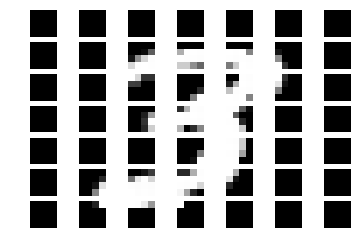

In [8]:
image_utils.graph_retinal_image(image, stride)

### Create SNN architecture

### Process the pixel stimulus for each retinal neuron

Process the image 1 pixel at a time

First create a set of neurons for each of the pixels. 
Assume 1-to-1 mapping, and no concept of a retinal unit. This will come later.

In [109]:
neurons = []
print('Creating {} x {} neurons'.format(len_x, len_y))
for y in range (0, len_y, 1):
    neuron_row=[]
    for x in range(0, len_x, 1):
        neuron_row.append(LIF.LIFNeuron(neuron_label="{}/{}".format(y,x), debug=debug))
    neurons.append(neuron_row)

Creating 28 x 28 neurons
LIFNeuron(0/0): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(0/1): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(0/2): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(0/3): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(0/4): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(0/5): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(0/6): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(0/7): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(0/8): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(0/9): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(0/10): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(0/11): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(0/12): Created Leaky Integrate and Fire neuron starting at time

In [110]:
start_x = 5
start_y = 5

print(len_x, len_y)

28 28


In [111]:
#for y in range(0, len_y, start_y + stride_size, 1):
#    for x in range(start_x, start_x + stride_size, 1):
for y in range(0, len_y, 1):
    for x in range(0, len_x, 1):
        stimulus = np.full((time), image_norm[y,x])
        print('Stimulus from image @ {}/{}: {}'.format(y, x, stimulus))
        print('Processing spike generator for neuron {}/{}: {}'.format(y,x,neurons[y][x].neuron_label))
        neurons[y][x].spike_generator(stimulus)
        print('Stats for neuron {},{}: time={}, stimulus={}, spikes={}' \
              .format(x,y,time, stimulus.shape, neurons[y][x].spikes)) #.shape))
        #graph.plot_membrane_potential(neurons[neuron_x][neuron_y].time, neurons[neuron_x][neuron_y].Vm, 'Membrane Potential {}'.format(neurons[neuron_x][neuron_y].type), neuron_id = "{}/{}".format(neuron_x, neuron_y))
        #graph.plot_spikes(neurons[neuron_x][neuron_y].time, neurons[neuron_x][neuron_y].spikes, 'Output spikes for {}'.format(neurons[neuron_x][neuron_y].type), neuron_id = "{}/{}".format(neuron_x, neuron_y))

Stimulus from image @ 0/0: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 0/0: 0/0
LIFNeuron.spike_generator(0/0).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(0/0).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 0,0: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 0/1: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 0/1: 0/1
LIFNeuron.spike_generator(0/1).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(0/1).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 1,0: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 0/2: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 0/2: 0/2
LIFNeuron.spike_generator(0/2).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.s

LIFNeuron.spike_generator(1/13).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 13,1: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 1/14: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 1/14: 1/14
LIFNeuron.spike_generator(1/14).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(1/14).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 14,1: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 1/15: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 1/15: 1/15
LIFNeuron.spike_generator(1/15).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(1/15).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 15,1: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 1/16: [ 0.  0

LIFNeuron.spike_generator(2/27).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(2/27).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 27,2: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 3/0: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 3/0: 3/0
LIFNeuron.spike_generator(3/0).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(3/0).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 0,3: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 3/1: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 3/1: 3/1
LIFNeuron.spike_generator(3/1).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(3/1).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 1,3: time=

LIFNeuron.spike_generator(4/11).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(4/11).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 11,4: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 4/12: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 4/12: 4/12
LIFNeuron.spike_generator(4/12).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(4/12).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 12,4: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 4/13: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 4/13: 4/13
LIFNeuron.spike_generator(4/13).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(4/13).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron

LIFNeuron.spike_generator(6/2).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(6/2).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 2,6: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 6/3: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 6/3: 6/3
LIFNeuron.spike_generator(6/3).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(6/3).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 3,6: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 6/4: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 6/4: 6/4
LIFNeuron.spike_generator(6/4).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(6/4).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 4,6: time=160

  0.99215686]
Processing spike generator for neuron 7/16: 7/16
LIFNeuron.spike_generator(7/16).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
*** LIFNeuron.spike_generator(7/16).spike=(self.t_rest=18.125, self.t=14.125, self.tau_ref=4)
*** LIFNeuron.spike_generator(7/16).spike=(self.t_rest=36.25, self.t=32.25, self.tau_ref=4)
*** LIFNeuron.spike_generator(7/16).spike=(self.t_rest=54.375, self.t=50.375, self.tau_ref=4)
*** LIFNeuron.spike_generator(7/16).spike=(self.t_rest=72.5, self.t=68.5, self.tau_ref=4)
*** LIFNeuron.spike_generator(7/16).spike=(self.t_rest=90.625, self.t=86.625, self.tau_ref=4)
*** LIFNeuron.spike_generator(7/16).spike=(self.t_rest=108.75, self.t=104.75, self.tau_ref=4)
*** LIFNeuron.spike_generator(7/16).spike=(self.t_rest=126.875, self.t=122.875, self.tau_ref=4)
*** LIFNeuron.spike_generator(7/16).spike=(self.t_rest=145.0, self.t=141.0, self.tau_ref=4)
*** LIFNeuron.spike_generator(7/16).spike=(self.t_rest=163.125, self.t=159.125, se

Stats for neuron 1,9: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 9/2: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 9/2: 9/2
LIFNeuron.spike_generator(9/2).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(9/2).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 2,9: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 9/3: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 9/3: 9/3
LIFNeuron.spike_generator(9/3).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(9/3).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 3,9: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 9/4: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 9/4: 9/4
LIFNeuron.spike_generator(9/4)

LIFNeuron.spike_generator(11/4).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(11/4).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 4,11: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 11/5: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 11/5: 11/5
LIFNeuron.spike_generator(11/5).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(11/5).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 5,11: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 11/6: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 11/6: 11/6
LIFNeuron.spike_generator(11/6).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(11/6).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron

Stats for neuron 0,13: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 13/1: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 13/1: 13/1
LIFNeuron.spike_generator(13/1).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(13/1).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 1,13: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 13/2: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 13/2: 13/2
LIFNeuron.spike_generator(13/2).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(13/2).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 2,13: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 13/3: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 13/3: 13/3
LIFNeuron.spik

Processing spike generator for neuron 14/22: 14/22
LIFNeuron.spike_generator(14/22).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(14/22).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 22,14: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 14/23: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 14/23: 14/23
LIFNeuron.spike_generator(14/23).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(14/23).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 23,14: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 14/24: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 14/24: 14/24
LIFNeuron.spike_generator(14/24).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(14/24).exit_s

Stats for neuron 1,16: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 16/2: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 16/2: 16/2
LIFNeuron.spike_generator(16/2).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(16/2).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 2,16: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 16/3: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 16/3: 16/3
LIFNeuron.spike_generator(16/3).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(16/3).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 3,16: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 16/4: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 16/4: 16/4
LIFNeuron.spik

Stats for neuron 20,17: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 17/21: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 17/21: 17/21
LIFNeuron.spike_generator(17/21).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(17/21).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 21,17: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 17/22: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 17/22: 17/22
LIFNeuron.spike_generator(17/22).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(17/22).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 22,17: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 17/23: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 17/23: 17/2

*** LIFNeuron.spike_generator(19/17).spike=(self.t_rest=126.875, self.t=122.875, self.tau_ref=4)
*** LIFNeuron.spike_generator(19/17).spike=(self.t_rest=145.0, self.t=141.0, self.tau_ref=4)
*** LIFNeuron.spike_generator(19/17).spike=(self.t_rest=163.125, self.t=159.125, self.tau_ref=4)
*** LIFNeuron.spike_generator(19/17).spike=(self.t_rest=181.25, self.t=177.25, self.tau_ref=4)
*** LIFNeuron.spike_generator(19/17).spike=(self.t_rest=199.375, self.t=195.375, self.tau_ref=4)
LIFNeuron.spike_generator(19/17).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 17,19: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 19/18: [ 0.98039216  0.98039216  0.98039216 ...,  0.98039216  0.98039216
  0.98039216]
Processing spike generator for neuron 19/18: 19/18
LIFNeuron.spike_generator(19/18).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
*** LIFNeuron.spike_generator(19/18).spike=(self.t_rest=18.5, self.t=14.

Processing spike generator for neuron 20/27: 20/27
LIFNeuron.spike_generator(20/27).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(20/27).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 27,20: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 21/0: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 21/0: 21/0
LIFNeuron.spike_generator(21/0).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(21/0).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 0,21: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 21/1: [ 0.  0.  0. ...,  0.  0.  0.]
Processing spike generator for neuron 21/1: 21/1
LIFNeuron.spike_generator(21/1).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(21/1).exit_state(Vm=(16

*** LIFNeuron.spike_generator(22/13).spike=(self.t_rest=173.5, self.t=169.5, self.tau_ref=4)
LIFNeuron.spike_generator(22/13).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 13,22: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 22/14: [ 0.31372549  0.31372549  0.31372549 ...,  0.31372549  0.31372549
  0.31372549]
Processing spike generator for neuron 22/14: 22/14
LIFNeuron.spike_generator(22/14).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(22/14).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)
Stats for neuron 14,22: time=1600, stimulus=(1600,), spikes=[ 0.  0.  0. ...,  0.  0.  0.]
Stimulus from image @ 22/15: [ 0.03529412  0.03529412  0.03529412 ...,  0.03529412  0.03529412
  0.03529412]
Processing spike generator for neuron 22/15: 22/15
LIFNeuron.spike_generator(22/15).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron

*** LIFNeuron.spike_generator(24/7).spike=(self.t_rest=18.125, self.t=14.125, self.tau_ref=4)
*** LIFNeuron.spike_generator(24/7).spike=(self.t_rest=36.25, self.t=32.25, self.tau_ref=4)
*** LIFNeuron.spike_generator(24/7).spike=(self.t_rest=54.375, self.t=50.375, self.tau_ref=4)
*** LIFNeuron.spike_generator(24/7).spike=(self.t_rest=72.5, self.t=68.5, self.tau_ref=4)
*** LIFNeuron.spike_generator(24/7).spike=(self.t_rest=90.625, self.t=86.625, self.tau_ref=4)
*** LIFNeuron.spike_generator(24/7).spike=(self.t_rest=108.75, self.t=104.75, self.tau_ref=4)
*** LIFNeuron.spike_generator(24/7).spike=(self.t_rest=126.875, self.t=122.875, self.tau_ref=4)
*** LIFNeuron.spike_generator(24/7).spike=(self.t_rest=145.0, self.t=141.0, self.tau_ref=4)
*** LIFNeuron.spike_generator(24/7).spike=(self.t_rest=163.125, self.t=159.125, self.tau_ref=4)
*** LIFNeuron.spike_generator(24/7).spike=(self.t_rest=181.25, self.t=177.25, self.tau_ref=4)
*** LIFNeuron.spike_generator(24/7).spike=(self.t_rest=199.375, 

### Sample a neuron to see how it behaves under stimulus from the image

In [112]:
ny, nx = 5, 21
print(neurons[ny][nx].time.shape)
print(neurons[ny][nx].spikes.shape)
print(neurons[ny][nx].Vm.shape)

(1601,)
(1601,)
(1601,)


In [113]:
print(neurons[ny][nx].neuron_label)

5/21


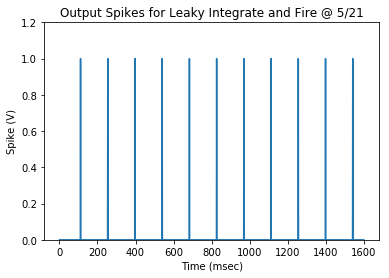

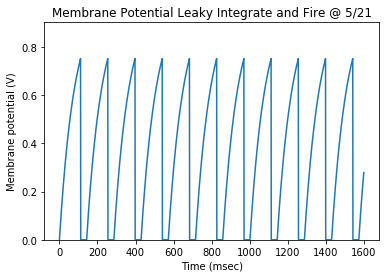

In [114]:
graph.plot_spikes(neurons[ny][nx].time, neurons[ny][nx].spikes, 
            'Output Spikes for {}'.format(neurons[ny][nx].type), neuron_id = '{}/{}'.format(ny, nx))
graph.plot_membrane_potential(neurons[ny][nx].time, neurons[ny][nx].Vm, 
            'Membrane Potential {}'.format(neurons[ny][nx].type), neuron_id = '{}/{}'.format(ny, nx))

## L2: Sum spikes into a neuron in the next layer

Create neurons in layer 2

In [115]:
l2_neurons_x = int(len_x / stride[0])
l2_neurons_y = int(len_y / stride[0])
print ('Creating layer 2 neurons: {} by {}'.format(l2_neurons_y, l2_neurons_x))

Creating layer 2 neurons: 7 by 7


In [116]:
l2_neurons = []

for y in range(l2_neurons_y):
    l2_neuron_row = []
    for x in range(l2_neurons_x):
        l2_neuron_row.append(LIF.LIFNeuron(neuron_label="L2:{}/{}".format(y,x), debug=debug))
    l2_neurons.append(l2_neuron_row)

LIFNeuron(L2:0/0): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(L2:0/1): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(L2:0/2): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(L2:0/3): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(L2:0/4): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(L2:0/5): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(L2:0/6): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(L2:1/0): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(L2:1/1): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(L2:1/2): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(L2:1/3): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(L2:1/4): Created Leaky Integrate and Fire neuron starting at time 0
LIFNeuron(L2:1/5): Created Leaky Integrate and Fire neuron start

Now process by retinal unit (x:x+stride, y:y+stride) and propogate spikes into the 2nd layer

In [117]:
l2_neuron_stimulus = np.zeros((l2_neurons_y, l2_neurons_x, time))

In [118]:
mult_factor = 49           # Number of neurons for each pixel (this is a hack to reduce processing earlier,... 
                          # raise to 49 perhaps later!)
l2x, l2y = 0,0
for ry in range (0, len_y, stride[0]):
    l2x = 0
    for rx in range(0, len_x, stride[0]):
        #x_end = rx + stride[0]
        #y_end = ry + stride[0]       
        stimulus_ret_unit = np.zeros(time)
        print('Generating stimulus for L2 neurons {}/{}'.format(l2y, l2x))
        for ny in range(stride[0]):
            for nx in range(stride[0]):
                x = rx + nx
                y = ry + ny
                #print ('Processing stimulus for L1 neuron at {},{}'.format(y,x))
                #print ('Adding stimulus {}'.format(neurons[y][x].spikes[:time]))
                stimulus_ret_unit += neurons[y][x].spikes[:time] * mult_factor
        print ('Adding stimulus for l2 neuron {},{}, duration={}\n'.format(l2y, l2x, len(stimulus_ret_unit)))
        l2_neuron_stimulus[l2y,l2x,:] = stimulus_ret_unit
        l2x += 1
    l2y += 1


Generating stimulus for L2 neurons 0/0
Adding stimulus for l2 neuron 0,0, duration=1600

Generating stimulus for L2 neurons 0/1
Adding stimulus for l2 neuron 0,1, duration=1600

Generating stimulus for L2 neurons 0/2
Adding stimulus for l2 neuron 0,2, duration=1600

Generating stimulus for L2 neurons 0/3
Adding stimulus for l2 neuron 0,3, duration=1600

Generating stimulus for L2 neurons 0/4
Adding stimulus for l2 neuron 0,4, duration=1600

Generating stimulus for L2 neurons 0/5
Adding stimulus for l2 neuron 0,5, duration=1600

Generating stimulus for L2 neurons 0/6
Adding stimulus for l2 neuron 0,6, duration=1600

Generating stimulus for L2 neurons 1/0
Adding stimulus for l2 neuron 1,0, duration=1600

Generating stimulus for L2 neurons 1/1
Adding stimulus for l2 neuron 1,1, duration=1600

Generating stimulus for L2 neurons 1/2
Adding stimulus for l2 neuron 1,2, duration=1600

Generating stimulus for L2 neurons 1/3
Adding stimulus for l2 neuron 1,3, duration=1600

Generating stimulus f

In [119]:
# print(l2_neuron_stimulus)

### Run spikes through L2 Neurons

In [120]:
for y in range(l2_neurons_y):
    for x in range(l2_neurons_x):
        print('\nProcessing L2 Neuron {},{} with stimulus length {}'.format(y,x,l2_neuron_stimulus[y][x]))
        l2_neurons[y][x].spike_generator(l2_neuron_stimulus[y][x])


Processing L2 Neuron 0,0 with stimulus length [ 0.  0.  0. ...,  0.  0.  0.]
LIFNeuron.spike_generator(L2:0/0).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(L2:0/0).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)

Processing L2 Neuron 0,1 with stimulus length [ 0.  0.  0. ...,  0.  0.  0.]
LIFNeuron.spike_generator(L2:0/1).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(L2:0/1).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)

Processing L2 Neuron 0,2 with stimulus length [ 0.  0.  0. ...,  0.  0.  0.]
LIFNeuron.spike_generator(L2:0/2).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(L2:0/2).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)

Processing L2 Neuron 0,3 with stimulus length [ 0.  0.  0. ...,  0.  0.  0.]
LIFNeuron.spike_generator(L2:0/3).initial_state(input=(1600,), duration=1600, initial Vm

LIFNeuron.spike_generator(L2:5/4).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)

Processing L2 Neuron 5,5 with stimulus length [ 0.  0.  0. ...,  0.  0.  0.]
LIFNeuron.spike_generator(L2:5/5).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(L2:5/5).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)

Processing L2 Neuron 5,6 with stimulus length [ 0.  0.  0. ...,  0.  0.  0.]
LIFNeuron.spike_generator(L2:5/6).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(L2:5/6).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)

Processing L2 Neuron 6,0 with stimulus length [ 0.  0.  0. ...,  0.  0.  0.]
LIFNeuron.spike_generator(L2:6/0).initial_state(input=(1600,), duration=1600, initial Vm=0.0, t=0, debug=True)
LIFNeuron.spike_generator(L2:6/0).exit_state(Vm=(1601,) at iteration i=1599, time=200.0)

Processing L2 Neuron 6,1 with stimulus length [ 0.  0.  0. ...,  0.  0.  0.]

### Now graph L2 neurons

Membrane potential

/Users/markstrefford/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


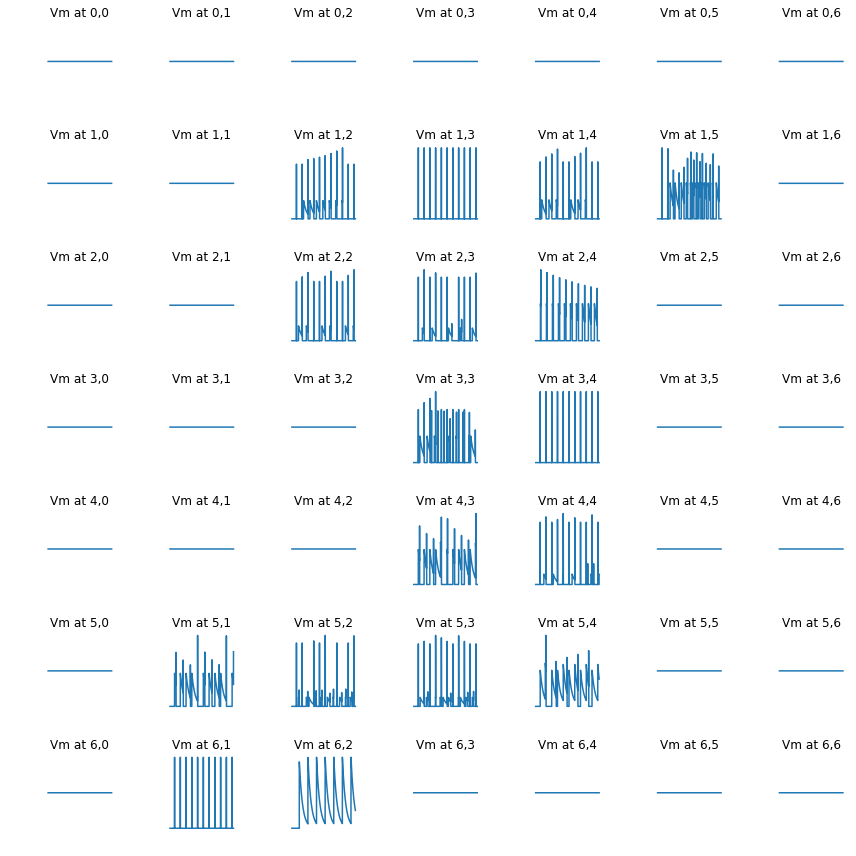

In [123]:
#fig, axes = plt.subplots(ncols=l2_neurons_x, nrows=l2_neurons_y, figsize=(10,10))
fig=plt.figure(figsize=(12,12))
fig.set_tight_layout({5,2,5})

for y in range(l2_neurons_y):
    for x in range(l2_neurons_x):
        index=(y)*l2_neurons_x+x+1
        id = "{}{}{}".format(l2_neurons_y, l2_neurons_x,index)
        a=fig.add_subplot(l2_neurons_y, l2_neurons_x, index)
        a.plot(l2_neurons[y][x].time, l2_neurons[y][x].Vm)
        a.axis('off')
        plt.title('Vm at {},{}'.format(y,x))
        
plt.show()

/Users/markstrefford/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


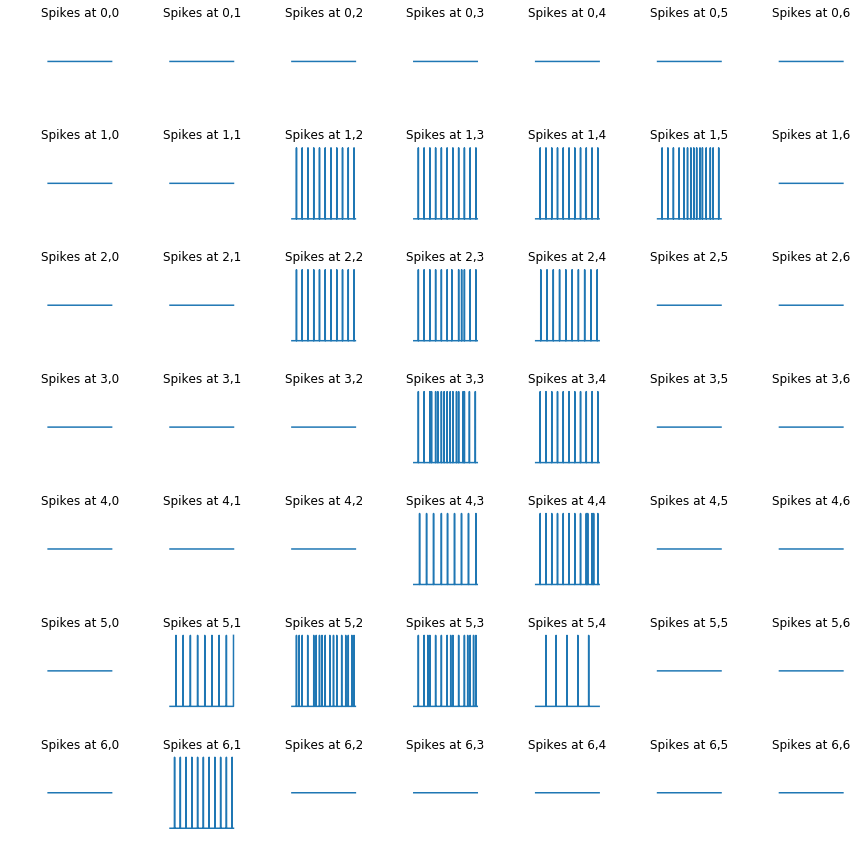

In [124]:
#fig, axes = plt.subplots(ncols=l2_neurons_x, nrows=l2_neurons_y, figsize=(10,10))
fig=plt.figure(figsize=(12,12))
fig.set_tight_layout({5,2,5})

for y in range(l2_neurons_y):
    for x in range(l2_neurons_x):
        index=(y)*l2_neurons_x+x+1
        id = "{}{}{}".format(l2_neurons_y, l2_neurons_x,index)
        a=fig.add_subplot(l2_neurons_y, l2_neurons_x, index)
        a.plot(l2_neurons[y][x].time, l2_neurons[y][x].spikes)
        a.axis('off')
        plt.title('Spikes at {},{}'.format(y,x))
        
plt.show()

## 